# MCMC算法原理

MCMC(Markov Chain Monte Carlo)马尔科夫蒙特卡洛算法是一种抽样方法。一般用于从贝叶斯产生出的后验分布中抽样。
因为若要应用一般抽样方法（如单元上的逆分布函数法），则要解出密度函数或分布函数，这就必须解出一个复杂的积分。
即

$$
f(P | D) = \frac{f(D|P)f(P)}{f(D)} = \frac{f(D|P)f(P)}{\int_P f(D|P)f(P)}
$$

中的分母。尽管分子，联合概率中由于参数的先验分布$f(P)$与似然关系$f(D|P)$都是给定的，只是一个乘积而已很好求。

MCMC算法的思路是让一个点在参数空间中漫游，其每次向邻域中的一个点移动，到达比较高的联合概率的点的概率较大，
到达联合概率比较小的概率较小（该过程可分为两步，1。以一个与所考察后验分布没关系的转移分布决定的转移目标，
2.但转移不转移过去则由后验分布联合概率决定。）。如此，当漫游足够长的次数$N$后，我们认为此时该点的分布
（从还没开始漫游的时刻看），就可以近似原本的后验分布。从而我们若想要抽$n$的样本，则要迭代$n$次，每次迭代从一个点开始漫游$N$次。

容易看出这样我们起码可以产生一个与原后验分布成某种比例的分布。
而事实上可以进一步证明，满足诸如遍历的条件（可以忘记初始点）时，下面的方法的确可以与后验分布相同的游历分布。

### Metropolis–Hastings算法

MH算法是一种特定的漫游方式，它指定一个漫游目标分布$g(x'|x)$。即根据当前点决定可能的下一个点的分布$x'$，
该分布可以是不对称的。选中一个点后，它以下面的概率转移到这个点，要么保留在原点：

$$
a = \frac{f(P'|D)}{f(P|D)} \frac{g(P|P')}{g(P'|P)} = \frac{f(D|P')f(P')}{f(D|P)f(P)} \frac{g(P|P')}{g(P'|P)}
$$

$a$可能大于$1$，此时当做概率为$1$。

这样可以产生一个参数空间点列$P_t$，其中初始$P_0$如果算法有效的话是不重要的，但它对收敛时间有一些影响。

我们展示一个正态分布的例子，下面以$N(1,1^2)$生成$100$个观测。先以频率主义看看它的点估计量的取值。



In [52]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
from IPython.core.pylabtools import figsize
import random
%matplotlib inline

matplotlib.rcParams.update({
  "lines.linewidth": 2.0,
  "axes.edgecolor": "#bcbcbc",
  "patch.linewidth": 0.5,
  "legend.fancybox": True,
  "axes.color_cycle": [
    "#348ABD",
    "#A60628",
    "#7A68A6",
    "#467821",
    "#CF4457",
    "#188487",
    "#E24A33"
  ],
  "axes.facecolor": "#eeeeee",
  "axes.labelsize": "large",
  "axes.grid": True,
  "patch.edgecolor": "#eeeeee",
  "axes.titlesize": "x-large",
  "svg.fonttype": "path",
  "examples.directory": ""
})

C:\Users\yiyuezhuo\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
true_mu = 1
true_sigma = 1
x = stats.norm(true_mu, true_sigma).rvs(100)

In [3]:
x.mean()

1.1792277116089431

In [4]:
x.std()

1.0387445862051432

In [35]:
def Metropolis(p0, P, g, n, log = True):
    '''
    p0: initial parameter
    P: p or p' -> R.  The product of likelihood and prior, the numerator of posterior prob including data information.
    g: p or p' -> distribution. (it should possess method `rvs` to sample and `pdf` to caclulate the prob of trasition.)
    n: walk step
    return trace
    '''
    trace = []
    p = p0
    for i in range(n):
        pp = g(p).rvs()
        Pr = P(pp, log = True) - P(p, log = True)
        gr = g(pp).pdf(p, log = True) - g(p).pdf(pp, log = True)
        a = np.exp(Pr + gr)
        a = min(a[0],1) * min(a[1],1)
        if random.random() < a:
            p = pp
        trace.append(p)
    return trace


In [76]:
def likelihood(P, x, log = True):
    '''L(P,X) = Prob(X|P)'''
    mu,sigma = P
    pdf = stats.norm(mu,sigma).pdf(x)
    if log:
        return np.log(pdf).sum()
    else:
        return pdf.prod()

def prior(P, log = True):
    mu,sigma = P
    prod = stats.norm(0,1).pdf(mu) * stats.norm(0,1).pdf(sigma)
    if log:
        return np.log(prod)
    return prod

def P(p, log = True):
    if log:
        return likelihood(p,x,log = True) + prior(p, log = True)
    else:
        return likelihood(p,x,log = False) * prior(p, log = False)

class fake_dis(object):
    def __init__(self, pdf, rvs):
        self.pdf = pdf
        self.rvs = rvs

def g(p, diversity = 0.1):
    mu_dis = stats.norm(p[0], diversity)
    sigma_dis = stats.norm(p[1], diversity)
    def pdf(pp, log = True):
        if log:
            return np.log(mu_dis.pdf(pp)) + np.log(sigma_dis.pdf(pp))
        return mu_dis.pdf(pp) * sigma_dis.pdf(pp)
    def rvs():
        return (mu_dis.rvs(), sigma_dis.rvs())
    return fake_dis(pdf = pdf, rvs = rvs)
n = 1000
p0 = (0,2)

In [77]:
%time trace = Metropolis(p0,P,g,n)

Wall time: 11 s


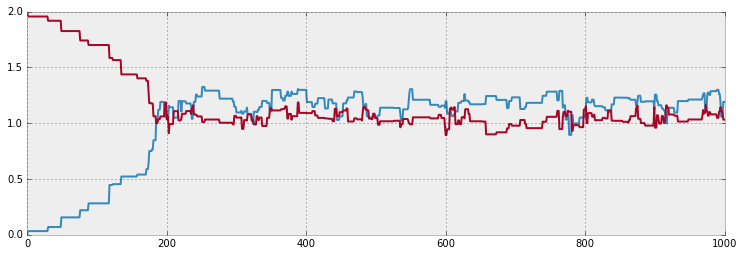

In [78]:
figsize(12.5,4)
plt.plot(trace)

In [83]:
burned_trace = trace[200:]
mean_trace, sigma_trace = zip(*burned_trace)

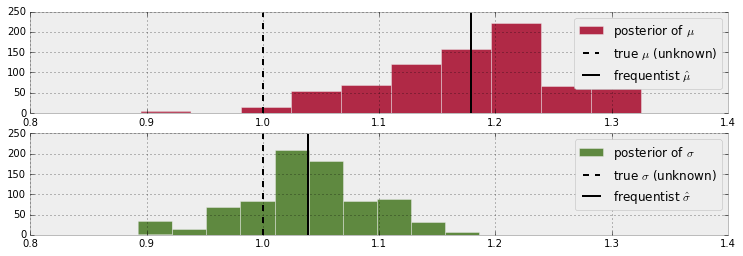

In [90]:
ax = plt.subplot(211)

plt.xlim(0.8,1.4)
plt.hist(mean_trace, color="#A60628", alpha=0.85, label= "posterior of $\mu$")
plt.vlines(true_mu, 0, 250, linestyle="--", label="true $\mu$ (unknown)")
plt.vlines(x.mean(), 0, 250, linestyle="-", label="frequentist $\hat{\mu}$")
plt.legend()

ax = plt.subplot(212)

plt.xlim(0.8,1.4)
plt.hist(sigma_trace, color="#467821", alpha=0.85, label= "posterior of $\sigma$")
plt.vlines(true_mu, 0, 250, linestyle="--", label="true $\sigma$ (unknown)")
plt.vlines(x.std(), 0, 250, linestyle="-", label="frequentist $\hat{\sigma}$")
plt.legend()


我们注意到这的确产生了有效的后验分布，其既包括真实值，也包括频率主义的估计值。

## trace采样与独立同分布采样

上面的采样方法并未进行$n \times N$次迭代。而是在一次轨迹中去掉前面有趋势的部分后剩下的轨迹全部作为样本计入。显然，这800个样本使用了8s才得到。
而如果采用虽然独立同分布但是开销巨大的$n \times N$迭代的话（迭代到200轮的值作为“已经遗忘初始点”，或者说当做burn in阶段结束，
从经验上看这这时就能当做度过burn in阶段算是比较乐观的估计），将需迭代$200 \times 800$次，大约消耗1600s。这当然是不可接受的。
由于轨迹之后看起来是在一个小区域内以同一个分布反复取值，于是每个样本可以当做独立的抽出的。

然而，仅从MH游走的设定来看，它更像随机游走，从而它根本不能当做是独立的抽出的，这可以从其必要条件，自相关系数上得以窥见：



In [94]:
import statsmodels.api as sm

In [99]:
def plot_acf_pacf(seq, lags = 40):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(seq, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(seq, lags=lags, ax=ax2)


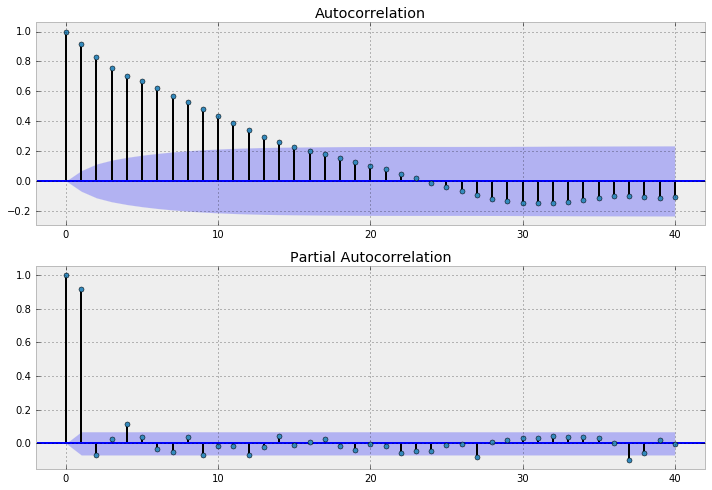

In [100]:
plot_acf_pacf(mean_trace)

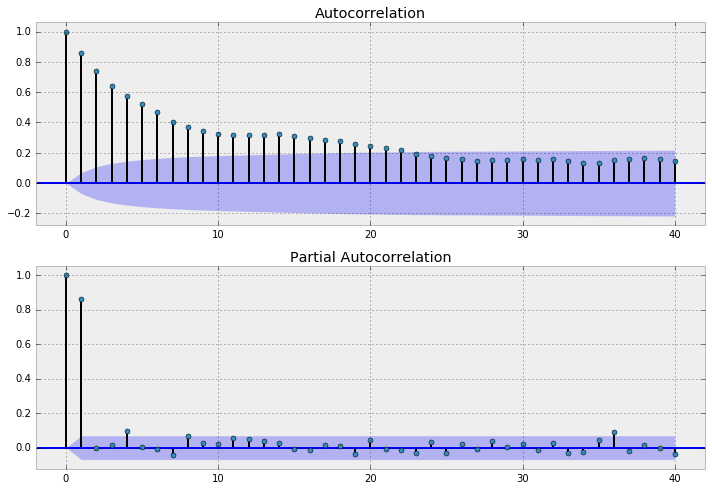

In [101]:
plot_acf_pacf(sigma_trace)

看上去是个标准的AR(1)模型，这怎么能看成是独立同分布的呢？当然，如果模拟次数足够大，遍历性可以保证我们的样本具有足够的代表性。
然而如果我们就把样本看成独立同分布的，同时用一些频率主义风格的东西分析样本量和方差之类的关系，就会产生问题，因为自相关会将方差变高，
或者说自相关序列的信息要比相同规模的独立同分布的序列少。一个粗略的降低自相关的方法是隔几个取一个。

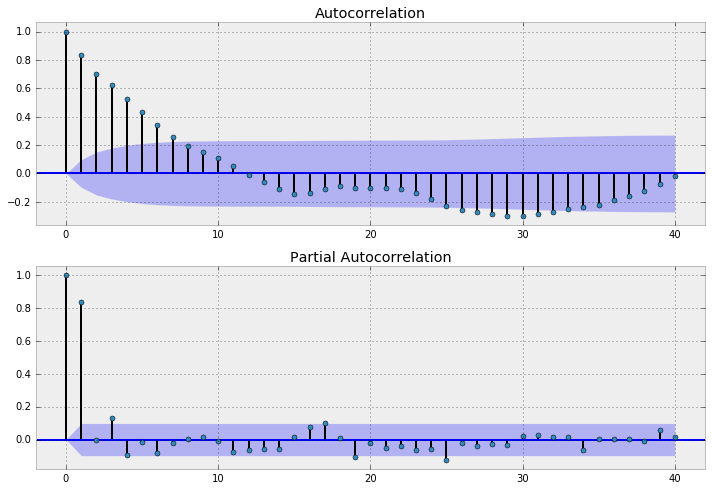

In [102]:
plot_acf_pacf(mean_trace[::2])

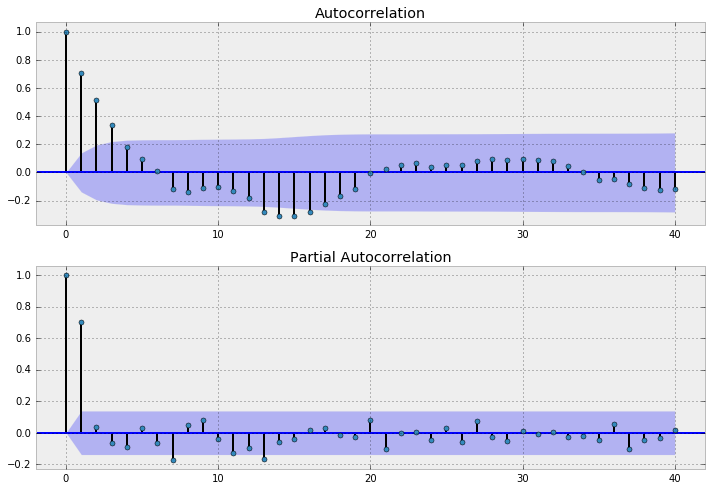

In [103]:
plot_acf_pacf(mean_trace[::4])

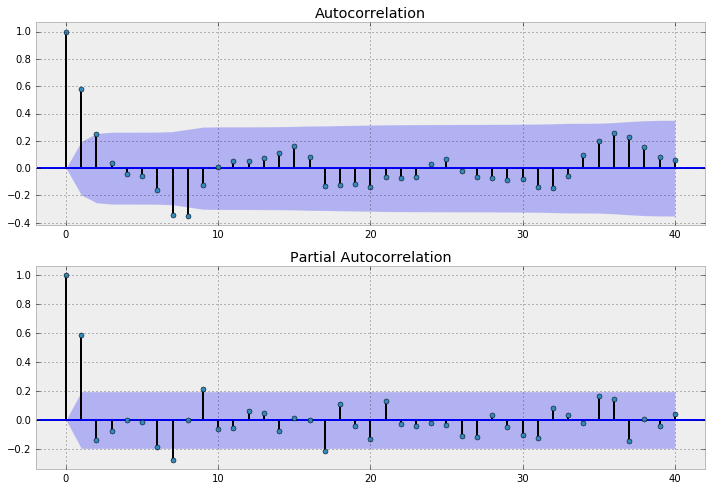

In [104]:
plot_acf_pacf(mean_trace[::8])

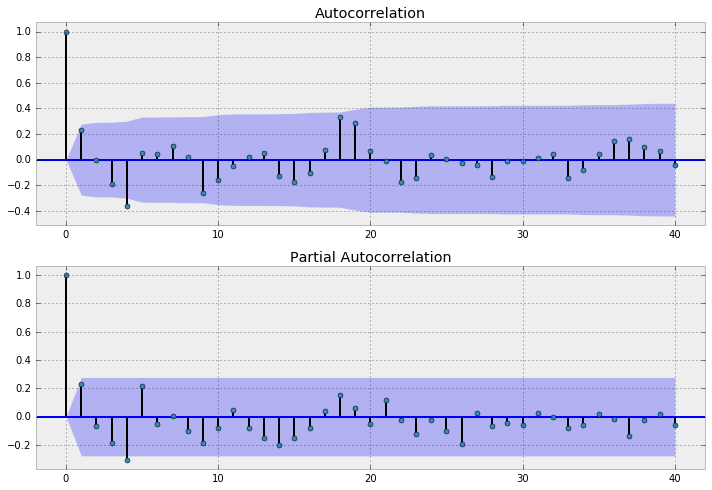

In [105]:
plot_acf_pacf(mean_trace[::16])

我们注意到随着弃掉的中间样本越多，自相关性也越小。这也是因为遍历性，在游历若干次后，它就“忘记”了它相对弃掉步数的初始点，自然就没有相关性了。
如此我们可以每迭代16步就产生一个相对独立的样本，比迭代200步才产生一个不知道高到哪里去（当然如果把搜索初始点就设在分布内就不用200步了）。